In [ ]:
# Bitcoin Price predictor - LSTM -

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

### Loading the Data

In [2]:
df = pd.read_csv("BTC-USD.csv")

## Preprocessing Data

In [3]:
# Setting the datetime index as the date, only selecting the 'Close' column, then only the last 1000 closing prices.
df = df.set_index("Date")[['Close']].tail(1000)
df = df.set_index(pd.to_datetime(df.index))

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [4]:
# Checking the newly formatted DataFrame
df.head()

,Close
Date,
2021-06-05,0.177825
2021-06-06,0.185797
2021-06-07,0.126688
2021-06-08,0.124426
2021-06-09,0.223876


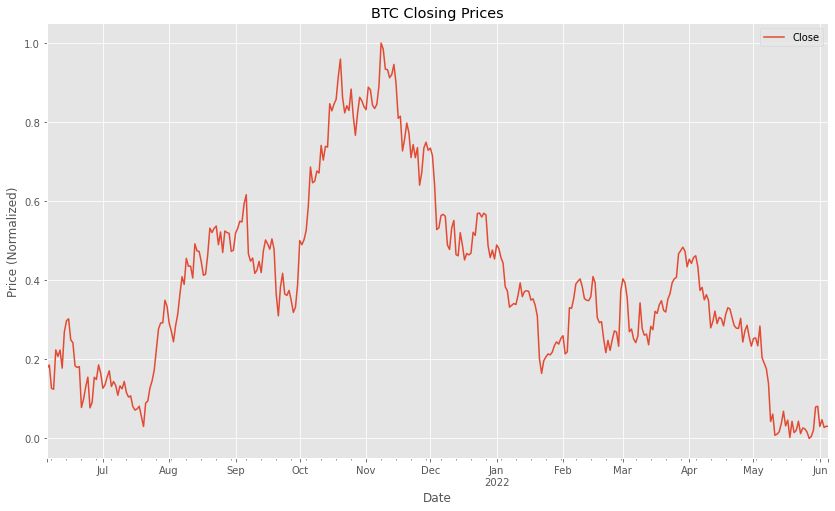

In [5]:
# Plotting the Closing Prices
df.plot(figsize=(14,8))
plt.title("BTC Closing Prices")
plt.ylabel("Price (Normalized)")
plt.show()

### Functions to prepare the data for LSTM

In [6]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [7]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [8]:
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

### Splitting the Data

In [9]:
# How many periods looking back to learn
n_per_in  = 30

# How many periods to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(list(df.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))


## Modeling - LSTM (RNN)

### Creating the Neural Network

In [10]:
# Instatiating the model
model = Sequential()

# Activation
activ = "softsign"

# Input layer
model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=6, n_nodes=12, activation=activ)

# Final Hidden layer
model.add(LSTM(10, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 30, 12)            2064      
                                                                 
 lstm_2 (LSTM)               (None, 30, 12)            1200      
                                                                 
 lstm_3 (LSTM)               (None, 30, 12)            1200      
                                                                 
 lstm_4 (LSTM)               (None, 30, 12)            1200      
                                                                 
 lstm_5 (LSTM)               (None, 30, 12)            1200      
                                                                 
 lstm_6 (LSTM)               (None, 30, 12)            1

In [13]:
# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

### Fitting and Training the RNN

In [14]:
res = model.fit(X, y, epochs=800, batch_size=32, validation_split=0.1)

Epoch 1/800
10/10 [==============================] - 7s 166ms/step - loss: 0.0022 - accuracy: 0.2959 - val_loss: 0.0127 - val_accuracy: 0.2424
Epoch 2/800
10/10 [==============================] - 1s 80ms/step - loss: 0.0015 - accuracy: 0.3333 - val_loss: 0.0107 - val_accuracy: 0.3030
Epoch 3/800
10/10 [==============================] - 1s 82ms/step - loss: 0.0014 - accuracy: 0.3231 - val_loss: 0.0100 - val_accuracy: 0.2727
Epoch 4/800
10/10 [==============================] - 1s 64ms/step - loss: 0.0014 - accuracy: 0.3299 - val_loss: 0.0160 - val_accuracy: 0.3030
Epoch 5/800
10/10 [==============================] - 1s 79ms/step - loss: 0.0013 - accuracy: 0.3469 - val_loss: 0.0123 - val_accuracy: 0.2727
Epoch 6/800
10/10 [==============================] - 1s 85ms/step - loss: 0.0013 - accuracy: 0.3503 - val_loss: 0.0157 - val_accuracy: 0.3030
Epoch 7/800
10/10 [==============================] - 1s 70ms/step - loss: 0.0012 - accuracy: 0.3435 - val_loss: 0.0140 - val_accuracy: 0.2727
Epoch

10/10 [==============================] - 1s 63ms/step - loss: 0.0010 - accuracy: 0.3571 - val_loss: 0.0119 - val_accuracy: 0.2727
Epoch 59/800
10/10 [==============================] - 1s 64ms/step - loss: 0.0011 - accuracy: 0.3537 - val_loss: 0.0140 - val_accuracy: 0.2727
Epoch 60/800
10/10 [==============================] - 1s 63ms/step - loss: 0.0011 - accuracy: 0.3503 - val_loss: 0.0151 - val_accuracy: 0.2727
Epoch 61/800
10/10 [==============================] - 1s 67ms/step - loss: 0.0011 - accuracy: 0.3503 - val_loss: 0.0151 - val_accuracy: 0.2424
Epoch 62/800
10/10 [==============================] - 1s 77ms/step - loss: 0.0012 - accuracy: 0.3299 - val_loss: 0.0139 - val_accuracy: 0.2727
Epoch 63/800
10/10 [==============================] - 1s 70ms/step - loss: 0.0011 - accuracy: 0.3571 - val_loss: 0.0122 - val_accuracy: 0.2424
Epoch 64/800
10/10 [==============================] - 1s 68ms/step - loss: 0.0012 - accuracy: 0.3435 - val_loss: 0.0123 - val_accuracy: 0.2727
Epoch 65/800

10/10 [==============================] - 1s 67ms/step - loss: 0.0010 - accuracy: 0.3571 - val_loss: 0.0137 - val_accuracy: 0.2727
Epoch 116/800
10/10 [==============================] - 1s 63ms/step - loss: 0.0010 - accuracy: 0.3537 - val_loss: 0.0149 - val_accuracy: 0.2424
Epoch 117/800
10/10 [==============================] - 1s 64ms/step - loss: 9.7054e-04 - accuracy: 0.3469 - val_loss: 0.0132 - val_accuracy: 0.2727
Epoch 118/800
10/10 [==============================] - 1s 64ms/step - loss: 9.4238e-04 - accuracy: 0.3435 - val_loss: 0.0123 - val_accuracy: 0.2727
Epoch 119/800
10/10 [==============================] - 1s 65ms/step - loss: 9.7739e-04 - accuracy: 0.3469 - val_loss: 0.0139 - val_accuracy: 0.2727
Epoch 120/800
10/10 [==============================] - 1s 65ms/step - loss: 9.7516e-04 - accuracy: 0.3639 - val_loss: 0.0124 - val_accuracy: 0.2727
Epoch 121/800
10/10 [==============================] - 1s 64ms/step - loss: 0.0010 - accuracy: 0.3571 - val_loss: 0.0139 - val_accurac

10/10 [==============================] - 1s 72ms/step - loss: 9.7830e-04 - accuracy: 0.3810 - val_loss: 0.0173 - val_accuracy: 0.3030
Epoch 172/800
10/10 [==============================] - 1s 76ms/step - loss: 9.6832e-04 - accuracy: 0.3639 - val_loss: 0.0144 - val_accuracy: 0.2727
Epoch 173/800
10/10 [==============================] - 1s 74ms/step - loss: 9.4794e-04 - accuracy: 0.3707 - val_loss: 0.0150 - val_accuracy: 0.2727
Epoch 174/800
10/10 [==============================] - 1s 79ms/step - loss: 9.2446e-04 - accuracy: 0.3571 - val_loss: 0.0149 - val_accuracy: 0.3030
Epoch 175/800
10/10 [==============================] - 1s 71ms/step - loss: 9.1453e-04 - accuracy: 0.3537 - val_loss: 0.0128 - val_accuracy: 0.3030
Epoch 176/800
10/10 [==============================] - 1s 73ms/step - loss: 9.8710e-04 - accuracy: 0.3503 - val_loss: 0.0152 - val_accuracy: 0.3030
Epoch 177/800
10/10 [==============================] - 1s 76ms/step - loss: 0.0010 - accuracy: 0.3844 - val_loss: 0.0165 - val

Epoch 227/800
10/10 [==============================] - 1s 71ms/step - loss: 8.9041e-04 - accuracy: 0.3741 - val_loss: 0.0154 - val_accuracy: 0.2727
Epoch 228/800
10/10 [==============================] - 1s 70ms/step - loss: 8.8608e-04 - accuracy: 0.3673 - val_loss: 0.0169 - val_accuracy: 0.3030
Epoch 229/800
10/10 [==============================] - 1s 72ms/step - loss: 8.9521e-04 - accuracy: 0.3673 - val_loss: 0.0169 - val_accuracy: 0.2727
Epoch 230/800
10/10 [==============================] - 1s 67ms/step - loss: 9.5559e-04 - accuracy: 0.3503 - val_loss: 0.0126 - val_accuracy: 0.2727
Epoch 231/800
10/10 [==============================] - 1s 68ms/step - loss: 8.9955e-04 - accuracy: 0.3503 - val_loss: 0.0163 - val_accuracy: 0.3030
Epoch 232/800
10/10 [==============================] - 1s 65ms/step - loss: 9.0464e-04 - accuracy: 0.3776 - val_loss: 0.0155 - val_accuracy: 0.3030
Epoch 233/800
10/10 [==============================] - 1s 72ms/step - loss: 0.0010 - accuracy: 0.3435 - val_loss

Epoch 283/800
10/10 [==============================] - 1s 63ms/step - loss: 8.8103e-04 - accuracy: 0.3707 - val_loss: 0.0134 - val_accuracy: 0.3030
Epoch 284/800
10/10 [==============================] - 1s 63ms/step - loss: 8.9769e-04 - accuracy: 0.3503 - val_loss: 0.0164 - val_accuracy: 0.3333
Epoch 285/800
10/10 [==============================] - 1s 64ms/step - loss: 8.5567e-04 - accuracy: 0.3639 - val_loss: 0.0163 - val_accuracy: 0.2727
Epoch 286/800
10/10 [==============================] - 1s 63ms/step - loss: 8.4996e-04 - accuracy: 0.4014 - val_loss: 0.0150 - val_accuracy: 0.2727
Epoch 287/800
10/10 [==============================] - 1s 79ms/step - loss: 8.4695e-04 - accuracy: 0.3571 - val_loss: 0.0147 - val_accuracy: 0.2727
Epoch 288/800
10/10 [==============================] - 1s 86ms/step - loss: 8.3166e-04 - accuracy: 0.3810 - val_loss: 0.0154 - val_accuracy: 0.3030
Epoch 289/800
10/10 [==============================] - 1s 72ms/step - loss: 8.0738e-04 - accuracy: 0.3912 - val_

10/10 [==============================] - 1s 64ms/step - loss: 8.8013e-04 - accuracy: 0.4116 - val_loss: 0.0164 - val_accuracy: 0.2727
Epoch 339/800
10/10 [==============================] - 1s 63ms/step - loss: 9.5169e-04 - accuracy: 0.4014 - val_loss: 0.0144 - val_accuracy: 0.2727
Epoch 340/800
10/10 [==============================] - 1s 66ms/step - loss: 0.0012 - accuracy: 0.3639 - val_loss: 0.0156 - val_accuracy: 0.2727
Epoch 341/800
10/10 [==============================] - 1s 66ms/step - loss: 0.0012 - accuracy: 0.3741 - val_loss: 0.0177 - val_accuracy: 0.3030
Epoch 342/800
10/10 [==============================] - 1s 66ms/step - loss: 0.0012 - accuracy: 0.3776 - val_loss: 0.0159 - val_accuracy: 0.3333
Epoch 343/800
10/10 [==============================] - 1s 64ms/step - loss: 0.0011 - accuracy: 0.3776 - val_loss: 0.0218 - val_accuracy: 0.3030
Epoch 344/800
10/10 [==============================] - 1s 65ms/step - loss: 0.0011 - accuracy: 0.3776 - val_loss: 0.0155 - val_accuracy: 0.272

Epoch 394/800
10/10 [==============================] - 1s 64ms/step - loss: 7.8427e-04 - accuracy: 0.4048 - val_loss: 0.0157 - val_accuracy: 0.2727
Epoch 395/800
10/10 [==============================] - 1s 64ms/step - loss: 7.7077e-04 - accuracy: 0.3844 - val_loss: 0.0172 - val_accuracy: 0.2727
Epoch 396/800
10/10 [==============================] - 1s 64ms/step - loss: 7.8551e-04 - accuracy: 0.3946 - val_loss: 0.0164 - val_accuracy: 0.2727
Epoch 397/800
10/10 [==============================] - 1s 65ms/step - loss: 7.9573e-04 - accuracy: 0.3980 - val_loss: 0.0182 - val_accuracy: 0.2727
Epoch 398/800
10/10 [==============================] - 1s 66ms/step - loss: 7.9070e-04 - accuracy: 0.3980 - val_loss: 0.0165 - val_accuracy: 0.3030
Epoch 399/800
10/10 [==============================] - 1s 64ms/step - loss: 7.8436e-04 - accuracy: 0.3912 - val_loss: 0.0175 - val_accuracy: 0.2727
Epoch 400/800
10/10 [==============================] - 1s 65ms/step - loss: 8.0042e-04 - accuracy: 0.4048 - val_

10/10 [==============================] - 1s 63ms/step - loss: 9.3161e-04 - accuracy: 0.3810 - val_loss: 0.0167 - val_accuracy: 0.2727
Epoch 450/800
10/10 [==============================] - 1s 64ms/step - loss: 8.3903e-04 - accuracy: 0.3878 - val_loss: 0.0182 - val_accuracy: 0.3030
Epoch 451/800
10/10 [==============================] - 1s 63ms/step - loss: 8.4860e-04 - accuracy: 0.4014 - val_loss: 0.0176 - val_accuracy: 0.2727
Epoch 452/800
10/10 [==============================] - 1s 63ms/step - loss: 7.6765e-04 - accuracy: 0.3844 - val_loss: 0.0186 - val_accuracy: 0.2727
Epoch 453/800
10/10 [==============================] - 1s 64ms/step - loss: 7.7186e-04 - accuracy: 0.3980 - val_loss: 0.0172 - val_accuracy: 0.2727
Epoch 454/800
10/10 [==============================] - 1s 64ms/step - loss: 7.6912e-04 - accuracy: 0.4048 - val_loss: 0.0176 - val_accuracy: 0.2727
Epoch 455/800
10/10 [==============================] - 1s 64ms/step - loss: 7.6323e-04 - accuracy: 0.3878 - val_loss: 0.0161 -

10/10 [==============================] - 1s 66ms/step - loss: 9.1107e-04 - accuracy: 0.3878 - val_loss: 0.0205 - val_accuracy: 0.2727
Epoch 505/800
10/10 [==============================] - 1s 66ms/step - loss: 8.0089e-04 - accuracy: 0.4218 - val_loss: 0.0157 - val_accuracy: 0.2727
Epoch 506/800
10/10 [==============================] - 1s 66ms/step - loss: 7.9203e-04 - accuracy: 0.4014 - val_loss: 0.0184 - val_accuracy: 0.2424
Epoch 507/800
10/10 [==============================] - 1s 64ms/step - loss: 8.0450e-04 - accuracy: 0.4048 - val_loss: 0.0181 - val_accuracy: 0.2727
Epoch 508/800
10/10 [==============================] - 1s 72ms/step - loss: 8.0227e-04 - accuracy: 0.4082 - val_loss: 0.0191 - val_accuracy: 0.2727
Epoch 509/800
10/10 [==============================] - 1s 65ms/step - loss: 8.3519e-04 - accuracy: 0.3639 - val_loss: 0.0180 - val_accuracy: 0.2727
Epoch 510/800
10/10 [==============================] - 1s 65ms/step - loss: 7.5123e-04 - accuracy: 0.3946 - val_loss: 0.0178 -

10/10 [==============================] - 1s 65ms/step - loss: 7.6706e-04 - accuracy: 0.3878 - val_loss: 0.0192 - val_accuracy: 0.2727
Epoch 560/800
10/10 [==============================] - 1s 66ms/step - loss: 7.4573e-04 - accuracy: 0.3980 - val_loss: 0.0207 - val_accuracy: 0.2727
Epoch 561/800
10/10 [==============================] - 1s 65ms/step - loss: 7.4626e-04 - accuracy: 0.4116 - val_loss: 0.0181 - val_accuracy: 0.2727
Epoch 562/800
10/10 [==============================] - 1s 71ms/step - loss: 7.3906e-04 - accuracy: 0.4082 - val_loss: 0.0201 - val_accuracy: 0.2424
Epoch 563/800
10/10 [==============================] - 1s 77ms/step - loss: 7.3167e-04 - accuracy: 0.4184 - val_loss: 0.0175 - val_accuracy: 0.2121
Epoch 564/800
10/10 [==============================] - 1s 79ms/step - loss: 7.3054e-04 - accuracy: 0.4014 - val_loss: 0.0201 - val_accuracy: 0.3030
Epoch 565/800
10/10 [==============================] - 1s 78ms/step - loss: 7.3003e-04 - accuracy: 0.4150 - val_loss: 0.0181 -

10/10 [==============================] - 1s 67ms/step - loss: 7.1074e-04 - accuracy: 0.4048 - val_loss: 0.0192 - val_accuracy: 0.2727
Epoch 615/800
10/10 [==============================] - 1s 67ms/step - loss: 7.4303e-04 - accuracy: 0.4116 - val_loss: 0.0209 - val_accuracy: 0.2121
Epoch 616/800
10/10 [==============================] - 1s 65ms/step - loss: 7.3056e-04 - accuracy: 0.3946 - val_loss: 0.0195 - val_accuracy: 0.2424
Epoch 617/800
10/10 [==============================] - 1s 64ms/step - loss: 7.5836e-04 - accuracy: 0.3980 - val_loss: 0.0214 - val_accuracy: 0.2424
Epoch 618/800
10/10 [==============================] - 1s 66ms/step - loss: 7.2784e-04 - accuracy: 0.4082 - val_loss: 0.0192 - val_accuracy: 0.2727
Epoch 619/800
10/10 [==============================] - 1s 65ms/step - loss: 7.3364e-04 - accuracy: 0.4116 - val_loss: 0.0206 - val_accuracy: 0.2121
Epoch 620/800
10/10 [==============================] - 1s 64ms/step - loss: 7.2580e-04 - accuracy: 0.3980 - val_loss: 0.0208 -

10/10 [==============================] - 1s 66ms/step - loss: 7.1704e-04 - accuracy: 0.4048 - val_loss: 0.0219 - val_accuracy: 0.2727
Epoch 670/800
10/10 [==============================] - 1s 71ms/step - loss: 7.0488e-04 - accuracy: 0.4014 - val_loss: 0.0205 - val_accuracy: 0.2121
Epoch 671/800
10/10 [==============================] - 1s 75ms/step - loss: 7.1570e-04 - accuracy: 0.4116 - val_loss: 0.0221 - val_accuracy: 0.2727
Epoch 672/800
10/10 [==============================] - 1s 66ms/step - loss: 7.1514e-04 - accuracy: 0.3912 - val_loss: 0.0232 - val_accuracy: 0.2727
Epoch 673/800
10/10 [==============================] - 1s 70ms/step - loss: 7.5206e-04 - accuracy: 0.3946 - val_loss: 0.0236 - val_accuracy: 0.2727
Epoch 674/800
10/10 [==============================] - 1s 73ms/step - loss: 7.8434e-04 - accuracy: 0.3810 - val_loss: 0.0221 - val_accuracy: 0.2424
Epoch 675/800
10/10 [==============================] - 1s 78ms/step - loss: 7.2327e-04 - accuracy: 0.3980 - val_loss: 0.0212 -

10/10 [==============================] - 1s 65ms/step - loss: 6.6492e-04 - accuracy: 0.4456 - val_loss: 0.0193 - val_accuracy: 0.2424
Epoch 725/800
10/10 [==============================] - 1s 66ms/step - loss: 6.5554e-04 - accuracy: 0.4252 - val_loss: 0.0212 - val_accuracy: 0.2727
Epoch 726/800
10/10 [==============================] - 1s 64ms/step - loss: 6.5444e-04 - accuracy: 0.4184 - val_loss: 0.0221 - val_accuracy: 0.2727
Epoch 727/800
10/10 [==============================] - 1s 65ms/step - loss: 6.7251e-04 - accuracy: 0.4252 - val_loss: 0.0180 - val_accuracy: 0.2424
Epoch 728/800
10/10 [==============================] - 1s 66ms/step - loss: 6.8657e-04 - accuracy: 0.4252 - val_loss: 0.0227 - val_accuracy: 0.2727
Epoch 729/800
10/10 [==============================] - 1s 64ms/step - loss: 6.6292e-04 - accuracy: 0.4150 - val_loss: 0.0207 - val_accuracy: 0.2727
Epoch 730/800
10/10 [==============================] - 1s 65ms/step - loss: 6.7526e-04 - accuracy: 0.4150 - val_loss: 0.0220 -

Epoch 780/800
10/10 [==============================] - 1s 64ms/step - loss: 6.4049e-04 - accuracy: 0.4014 - val_loss: 0.0204 - val_accuracy: 0.2727
Epoch 781/800
10/10 [==============================] - 1s 65ms/step - loss: 6.3630e-04 - accuracy: 0.3912 - val_loss: 0.0187 - val_accuracy: 0.2424
Epoch 782/800
10/10 [==============================] - 1s 64ms/step - loss: 6.3955e-04 - accuracy: 0.4014 - val_loss: 0.0205 - val_accuracy: 0.2727
Epoch 783/800
10/10 [==============================] - 1s 65ms/step - loss: 6.4561e-04 - accuracy: 0.4116 - val_loss: 0.0197 - val_accuracy: 0.2727
Epoch 784/800
10/10 [==============================] - 1s 66ms/step - loss: 6.4238e-04 - accuracy: 0.4252 - val_loss: 0.0200 - val_accuracy: 0.2727
Epoch 785/800
10/10 [==============================] - 1s 71ms/step - loss: 6.3225e-04 - accuracy: 0.4218 - val_loss: 0.0200 - val_accuracy: 0.2727
Epoch 786/800
10/10 [==============================] - 1s 71ms/step - loss: 6.3186e-04 - accuracy: 0.4150 - val_

### Plotting the Accuracy and Loss

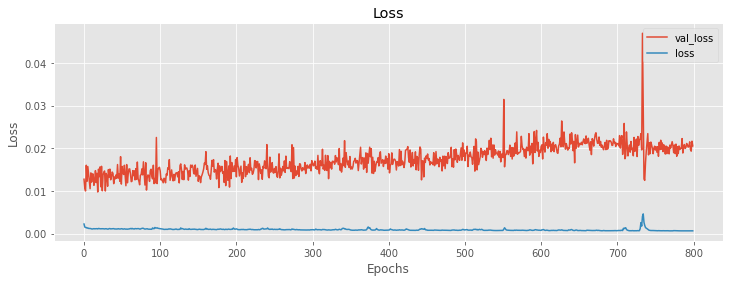

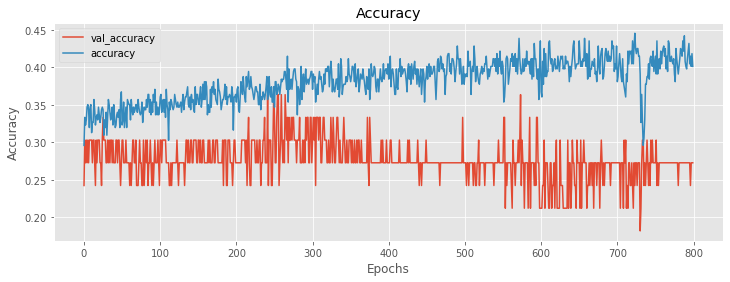

In [15]:
visualize_training_results(res)

## Visualizing the Predictions

### Validating the Model 
Plotting the difference between the Actual closing prices and the Predicted prices

Predicted Prices:
 [[35900.758532626794], [36412.156045328666], [36231.702534932454], [35906.036396569856], [35340.677715115045], [34457.67007274941], [33332.81603604302], [33064.680123284044], [33248.60956199501], [33787.33783397326]]

Actual Prices:
 [[28627.57422], [28814.90039], [29445.95703], [31726.39063], [31792.31055], [29799.080080000003], [30467.48828], [29704.39063], [29832.91406], [29805.44141]]


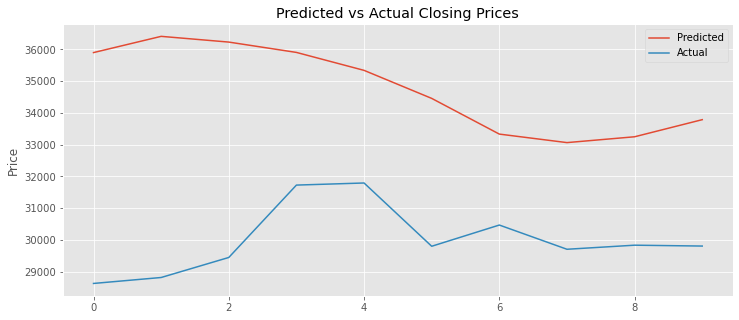

In [16]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.savefig("BTC_validation.png")
plt.show()

### Predicting/Forecasting the future prices

                   Close
2022-06-05  39243.094688
2022-06-06  39845.856226
2022-06-07  39459.512640
2022-06-08  40105.907074
2022-06-09  40057.682158
2022-06-10  40367.110278
2022-06-11  40785.220849
2022-06-12  41277.798274
2022-06-13  42695.272615
2022-06-14  43228.631635


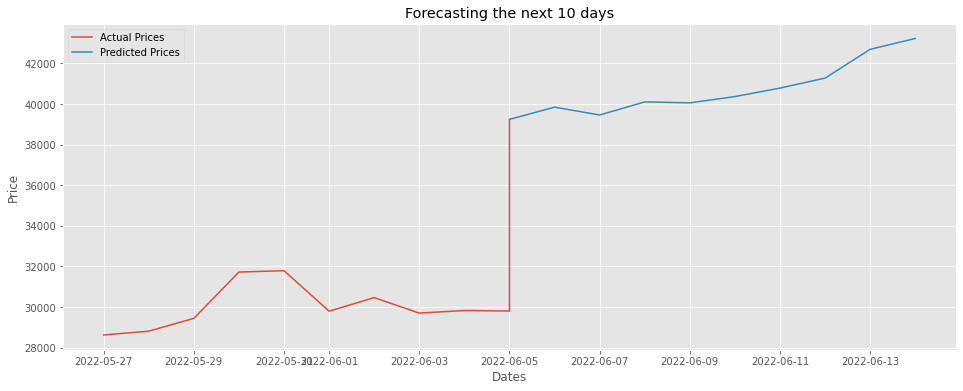

In [17]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["Close"]].tail(pers)), index=df.Close.tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()